<img src="img/python-logo-notext.svg"
     style="display:block;margin:auto;width:10%"/>
<h1 style="text-align:center;">Python: SARIMA</h1>
<h2 style="text-align:center;">Coding Akademie München GmbH</h2>
<br/>
<div style="text-align:center;">Dr. Matthias Hölzl</div>
<div style="text-align:center;">Allaithy Raed</div>

In [2]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('co2_mm_mlo.csv')

In [3]:
df.head()

year  month  decimal_date  average  interpolated
0  1958      3      1958.208   315.71        315.71
1  1958      4      1958.292   317.45        317.45
2  1958      5      1958.375   317.50        317.50
3  1958      6      1958.458      NaN        317.10
4  1958      7      1958.542   315.86        315.86

Erzeugen eines `DateTimeIndex` aus `year` und `month`.

In [4]:
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [5]:
df.set_index('date', inplace=True)
df.index.freq = 'MS'
df.head()

year  month  decimal_date  average  interpolated
date                                                        
1958-03-01  1958      3      1958.208   315.71        315.71
1958-04-01  1958      4      1958.292   317.45        317.45
1958-05-01  1958      5      1958.375   317.50        317.50
1958-06-01  1958      6      1958.458      NaN        317.10
1958-07-01  1958      7      1958.542   315.86        315.86

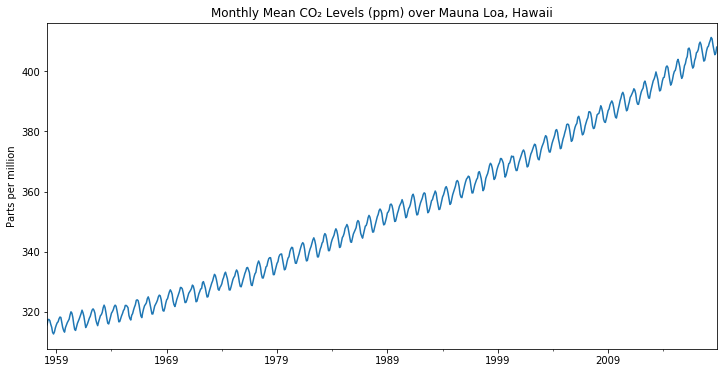

In [6]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'Parts per million'
xlabel = ''

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### ETS Dekomposition

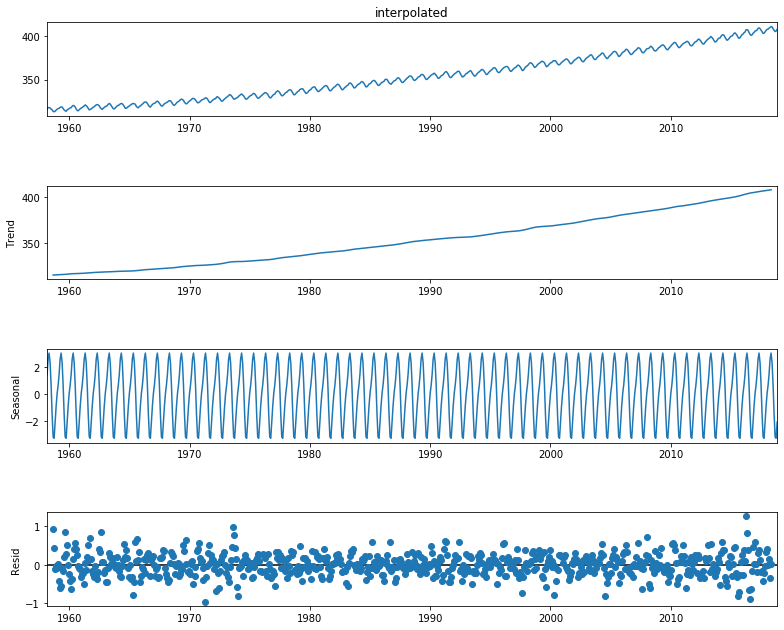

In [8]:
import matplotlib as plt
result = seasonal_decompose(df['interpolated'], model='add')
fig = result.plot();
fig.set_size_inches(12, 10)

### Feststellen der SARIMA Ordnung

In [11]:
# auto_arima(df['interpolated'], seasonal=True, m=12, trace=True).summary()

<img src="img/auto_arima.png" width="600"></img>

Das Ergebnis schlägt ARIMA Ordnung (0,1,3) mit saisonaler Ordnung (1,0,1,12) vor.
Wir müssen also ein SARIMA(0,1,3)(1,0,1,12)-Modell trainieren.

### Aufteilen der Daten in Train/Test Sets

In [13]:
len(df)

729

In [14]:
train = df.iloc[:717]
test = df.iloc[717:]

### SARIMA(0,1,3)(1,0,1,12) Modell

In [15]:
model = SARIMAX(train['interpolated'], order=(0,1,3), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.189
Date:                              Fri, 13 Mar 2020   AIC                            414.378
Time:                                      09:06:11   BIC                            441.820
Sample:                                  03-01-1958   HQIC                           424.975
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3542      0.036     -9.722      0.000      -0.426      -0.283
ma.L2         -0.0252      0.037     -0.680      0.496      -0.098       0.047
ma.L3         -0.0865      0.034     -2.510      0.012      -0.154      -0.019
ar.S.L12       0.9996      0.000   3032.405      0.000       0.999       1.000
ma.S.L12      -0.8656      0.023    -38.200      0.000      -0.910      -0.821
sigma2         0.0951      0.005     20.289      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.88   Jarque-Bera (JB):                 4.35
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end,
                              dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

In [18]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.6102328, expected=406.81
predicted=407.8256504, expected=407.96
predicted=408.5792823, expected=408.32
predicted=409.4843856, expected=409.41
predicted=411.041901 , expected=410.24
predicted=411.645123 , expected=411.24
predicted=410.864782 , expected=410.79
predicted=409.1743274, expected=408.71
predicted=407.0739545, expected=406.99
predicted=405.6237912, expected=405.51
predicted=405.8945899, expected=406.0
predicted=407.4285801, expected=408.02


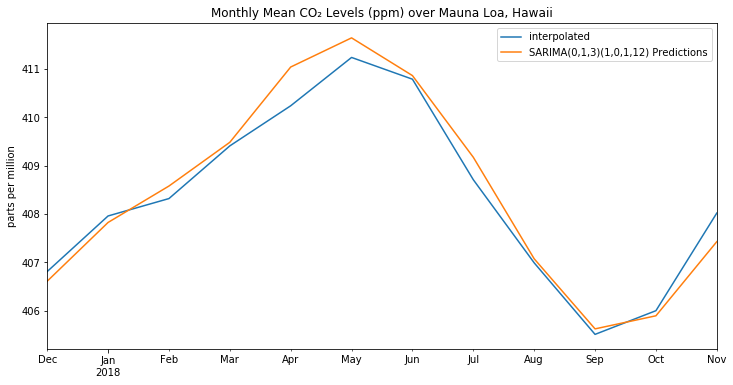

In [19]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'parts per million'
xlabel = ''

ax = test['interpolated'].plot(legend=True, figsize=(12,6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluieren des Modells

In [23]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1283304133


In [24]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3582323454


### Trainieren auf dem vollen Datensatz; Vorhersage

In [27]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
final_forecast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

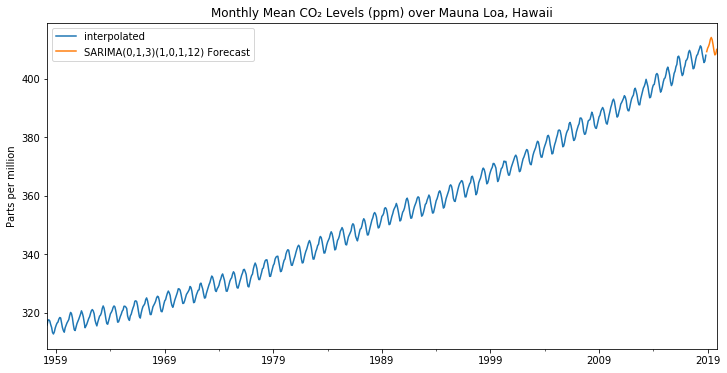

In [28]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'Parts per million'
xlabel =''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
final_forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

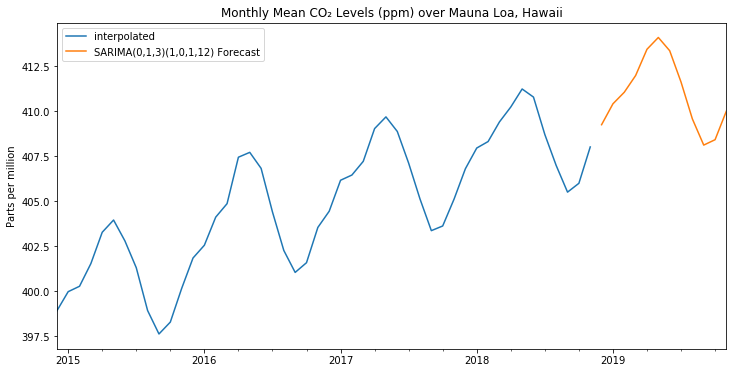

In [31]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel = 'Parts per million'
xlabel =''

ax = df['interpolated'].iloc[-48:].plot(legend=True,figsize=(12,6),title=title)
final_forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);